In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from skimage import io
from skimage.transform import rotate
from skimage.color import rgb2gray
from deskew import determine_skew

cv2.setRNGSeed(0)

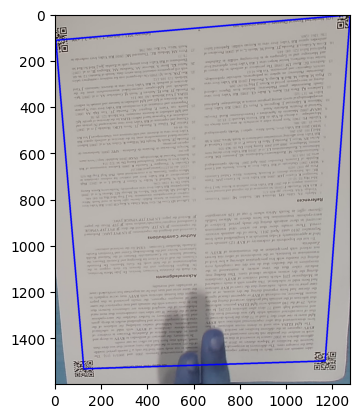

In [3]:
image = cv2.imread('/home/csgrad/indratej/my_projects/thesis/IC-dataset/final_cropped_aoi/_17.MP4_11930.png')
plt.imshow(image)

In [5]:
def threshold(image):
    #simple thresh
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,129,4)
    plt.imshow(~thresh,cmap='gray')
    plt.title('thresholded')
    plt.show()

    #erosion
    kernel = np.ones((3,3),np.uint8)
    erosion = thresh.copy()
    for i in range(5):
        erosion = cv2.erode(erosion,kernel,iterations = i)
        plt.imshow(~erosion,cmap='gray')
        plt.title('eroded-{}'.format(i))
        plt.show()

In [ ]:
threshold(image)

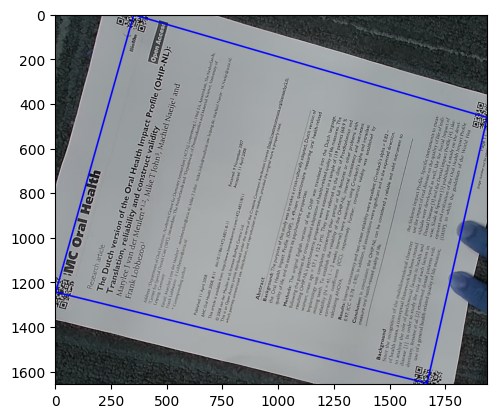

In [10]:
image2 = cv2.imread('/home/csgrad/indratej/my_projects/thesis/IC-dataset/final_cropped_aoi/_11.mp4_360.png')
plt.imshow(image2)

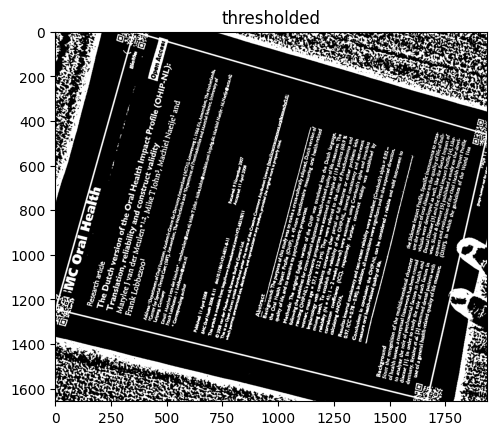

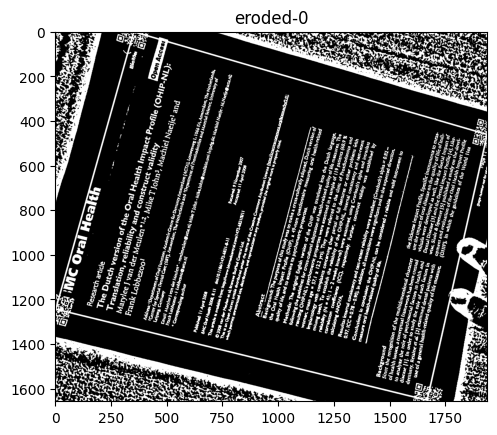

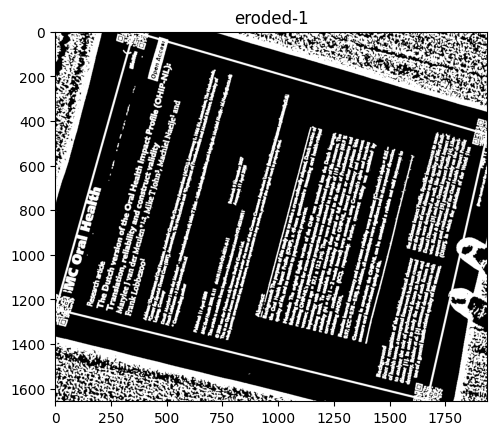

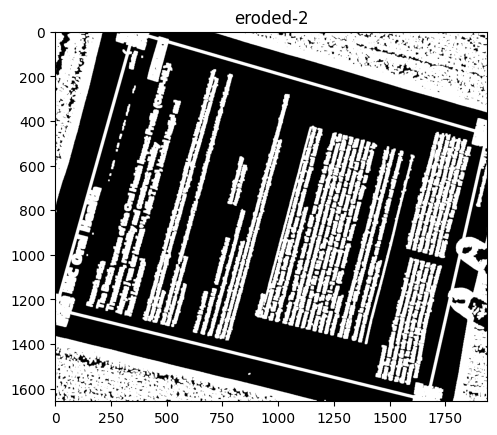

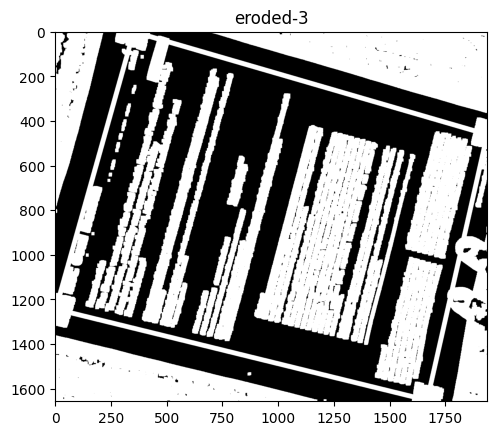

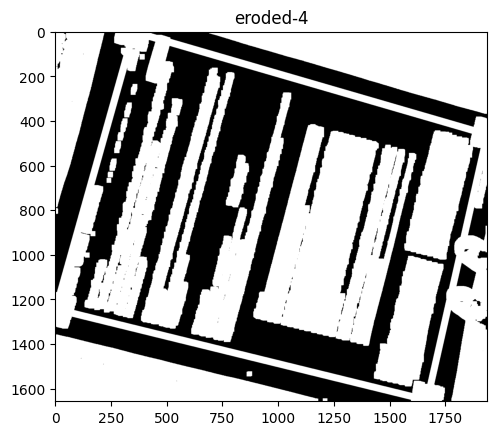

In [11]:
threshold(image2)

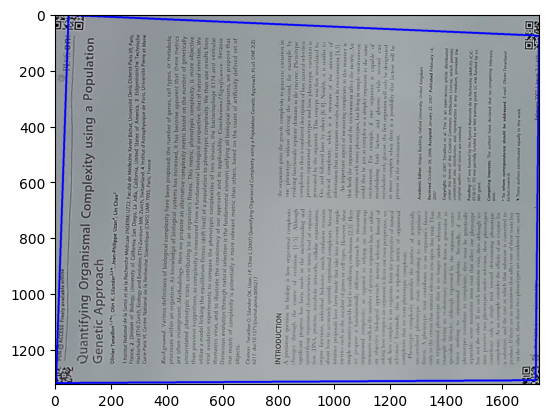

In [12]:
image3 = cv2.imread('/home/csgrad/indratej/my_projects/thesis/IC-dataset/final_cropped_aoi/_12.mp4_1986.png')
plt.imshow(image3)

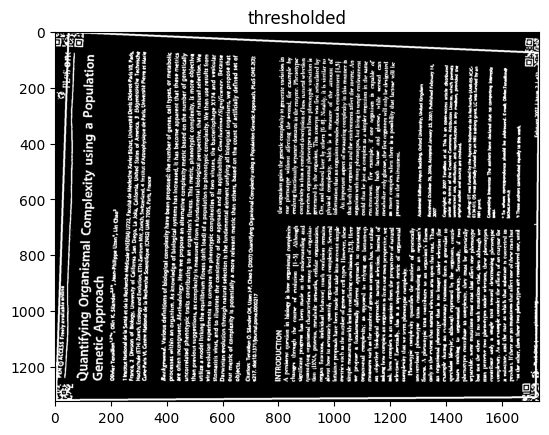

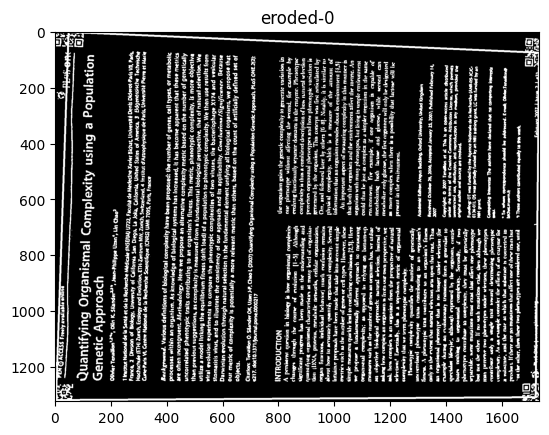

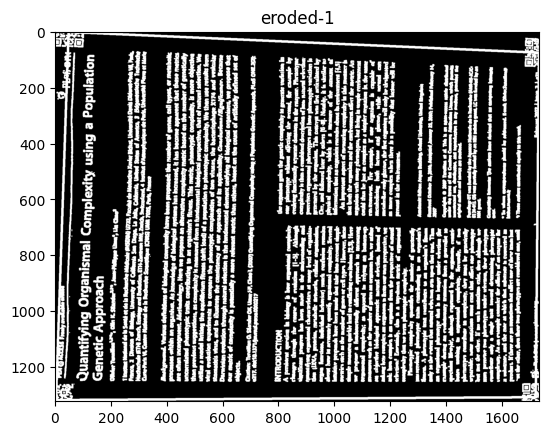

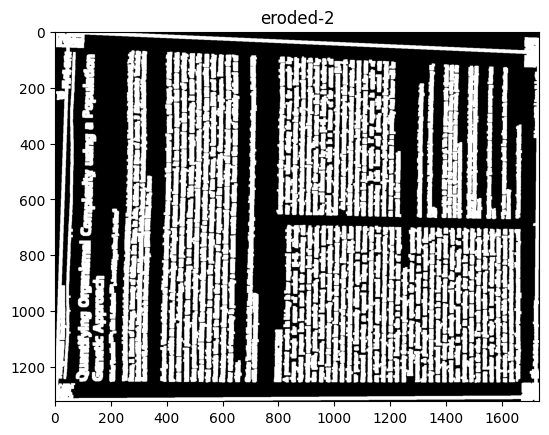

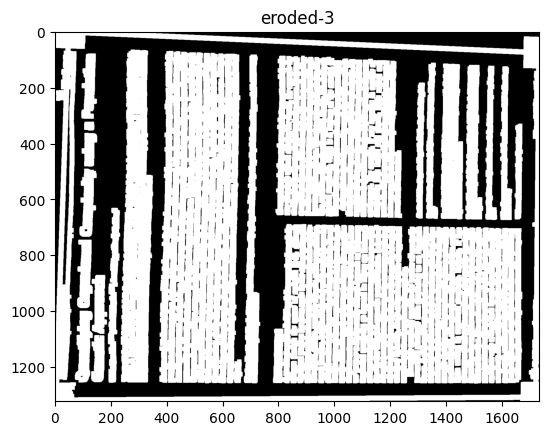

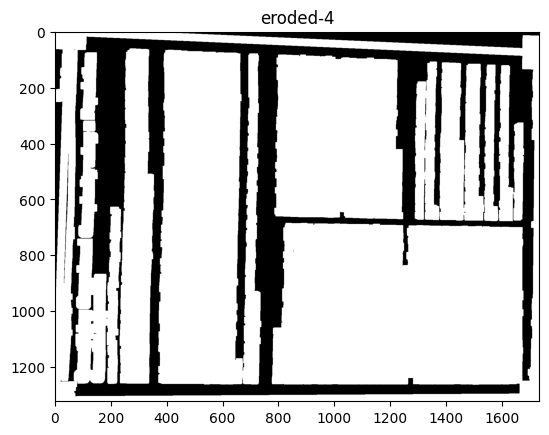

In [13]:
threshold(image3)

In [14]:
import cv2
import numpy as np
import skimage.exposure


In [35]:
def find_gradients(image):
    img = cv2.GaussianBlur(image, (0,0), sigmaX=1.5, sigmaY=1.5)

    Kx = np.array([[-1, 0, 1], 
                [-2, 0, 2], 
                [-1, 0, 1]])
    Ky = np.array([[1,   2,  1], 
                [0,   0,  0], 
                [-1,  -2, -1]])

    Ix = cv2.filter2D(img, -1, Kx)
    Iy = cv2.filter2D(img, -1, Ky)

    G = np.hypot(Ix, Iy)
    G = skimage.exposure.rescale_intensity(G, in_range='image', out_range=(0,255)).astype(np.uint8)

    theta = np.arctan2(Iy, Ix)
    theta = skimage.exposure.rescale_intensity(theta, in_range='image', out_range=(0,255)).astype(np.uint8)

    plt.imshow(image)
    plt.show()
    plt.imshow(img)
    plt.show()
    plt.imshow(G)
    plt.show()
    plt.imshow(theta, cmap='gray')
    plt.show()


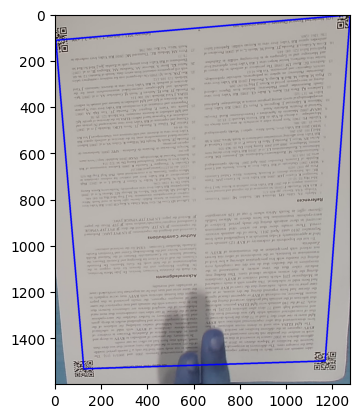

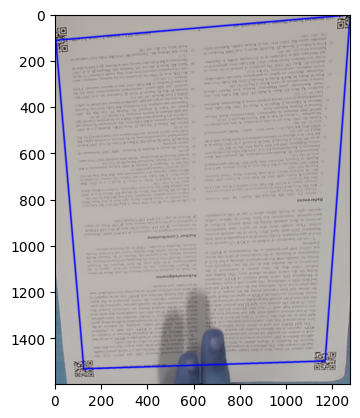

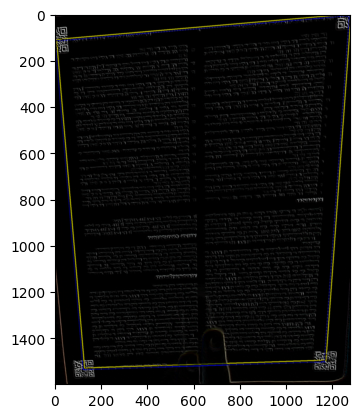

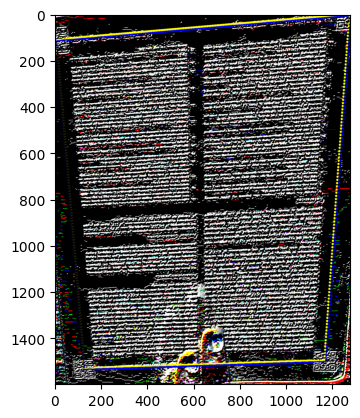

In [36]:
find_gradients(image)

In [21]:
image.shape

(1599, 1277, 3)

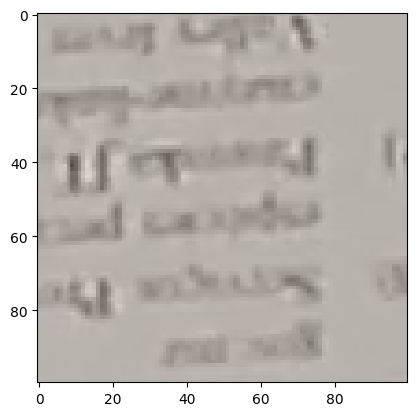

In [33]:
patch = image[500:600,500:600,:]
plt.imshow(patch)

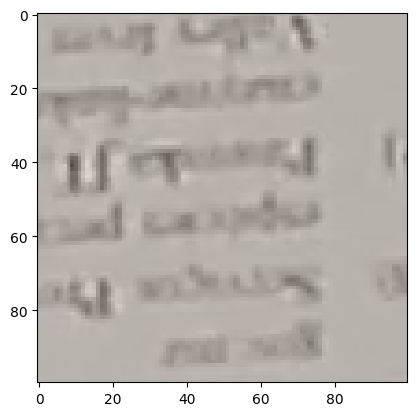

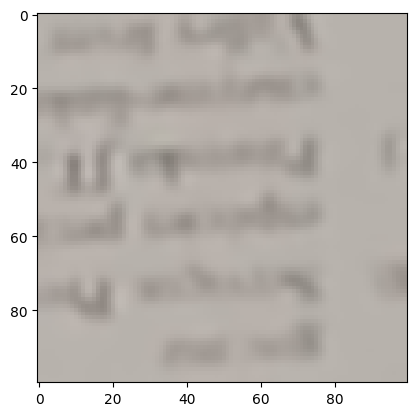

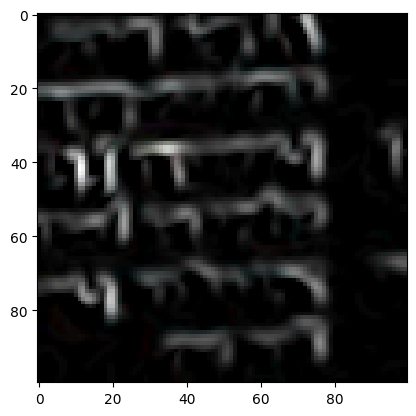

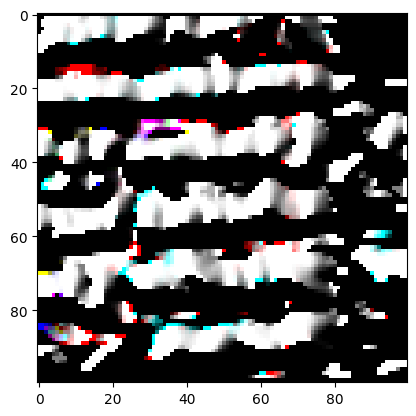

In [34]:
find_gradients(patch)

In [37]:
def binarize(image,size=(1200,1600), return_inter=False):
    image = cv2.resize(image,size,interpolation = cv2.INTER_LINEAR)
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # thresh = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY_INV)[1]
    thresh = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,129,4)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    result = 255 - opening

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    morph = cv2.morphologyEx(result, cv2.MORPH_CLOSE, kernel, iterations=1)
    mask = cv2.morphologyEx(morph, cv2.MORPH_OPEN, kernel, iterations=1)

    if return_inter:
        return [image, opening, result]
    return result, image

#generate_stats components into a dataframe
def generate_stats(totalLabels,stats, centroids):
    '''
    totalLabels,stats, centroids : cv2 connectedComponentsWithStats outputs
    '''
    columns = ['label_id', 'left','top','width','height','area','centroid_x','centroid_y']
    df = pd.DataFrame(columns=columns)
    df['label_id'] = [i for i in range(1,totalLabels+1)]
    df['left'] = stats[:,0]
    df['top'] = stats[:,1]
    df['width'] = stats[:,2]
    df['height'] = stats[:,3]
    df['area'] = stats[:,4]
    df['centroid_x'] = centroids[:,0]
    df['centroid_y'] = centroids[:,1]
    return df

#filter 
def filter_cv2_components(df, min_ar_thresh=1, max_ar_thresh=10,pixel_row_gap = 10):
    '''
    df : dataframe,
    min_ar_thresh : min aspect ratio threshold,
    max_ar_thresh : max aspect ratio threshold,
    pixel_row_gap : min gap b/w pixels to consider them in difft rows
    '''

    df['aspect_ratio'] = np.round(df['width']/df['height'],2)
    # df = df[(df['aspect_ratio'] > min_ar_thresh) & (df['aspect_ratio'] < max_ar_thresh)]  #filter by aspect-ratio
    # df = df[(df['area'] > min_area) & (df['area'] < max_area)]  #filter by area
    df = df.sort_values(by=['top', 'left']).reset_index(drop=True) #sort-by occurence
    
    #calculate rowID, colID
    df['rowID'] = 1
    row_id = 1
    prev_val = df.loc[0, 'top']
    for idx in range(1, df.shape[0]):
        curr_val = df.loc[idx, 'top']
        if curr_val - prev_val > pixel_row_gap:
            row_id += 1
        prev_val = curr_val
        df.at[idx, 'rowID'] = int(row_id)
    df['columnID'] = df.groupby('rowID')['left'].rank().astype(int)
    return df


def build_single_lexicon(label_id, df, k=5):
    '''
    label_id : word component id, 
    df : dataframe
    k : #neighbors to build context
    '''
    if label_id not in df['label_id'].values:
        print("unknown component")
        return
    
    #filter by current component and extract candidate neighbors
    x,y,w,h,r,c = df[df['label_id'] == label_id][['centroid_x','centroid_y','width','height','rowID','columnID']].values[0]
    r1 = (df['rowID'] >= r-1)
    r2 = (df['rowID'] <= r+1)    
    temp_df = df[r1 & r2]
    temp_df = temp_df[temp_df['label_id'] != label_id]
    
    #rotation-invariance - TBD during preprocessing
    
    #scale-invariance
    temp_df['new_centroid_x'] = (temp_df['centroid_x']-x)/w
    temp_df['new_centroid_y'] = (y-temp_df['centroid_y'])/h
    temp_df['new_left'] = (temp_df['left']-x)/w
    temp_df['new_top'] = (y-temp_df['top'])/h
    temp_df['new_width'] = temp_df['width']/w
    temp_df['new_height'] = temp_df['height']/h
    
    #calculate distance & angle
    temp_df['Euclidean'] = np.sqrt(temp_df['new_centroid_y']**2 + temp_df['new_centroid_x']**2)
    temp_df['theta'] = np.degrees(np.arctan2(temp_df['new_centroid_y'], temp_df['new_centroid_x']))
    temp_df['theta'] = (temp_df['theta'] + 360) % 360 
    temp_df.loc[temp_df['theta'] > 350, 'theta'] = 0 #heuristic
    temp_df.loc[temp_df['theta'] < 2, 'theta'] = 0 #heuristic
    temp_df['quadrant'] = pd.cut(temp_df['theta'], 8, labels=range(1,9))
    
    #sort and retreive top-K, format required coordinates.
    res_df = temp_df.sort_values(by=['Euclidean','theta'])[:k] #sort and get top-k neighbors
    res_df = res_df.sort_values(by=['theta'])
    res_df['tl_corner'] = res_df.apply(lambda row: (row['new_left'], row['new_top']), axis=1)
    res_df['br_corner'] = res_df.apply(lambda row: (row['new_left']+row['new_width'], row['new_top']+row['new_height']), axis=1)           
    return res_df


In [38]:
def build_context_layout(img,k_neigh = 5):
    '''
    img : image, 
    k_neigh : #neighbors to build context
    '''
    #preprocess and transform image
    thresh, img = binarize(img)
    totalLabels, labels, stats, centroid = cv2.connectedComponentsWithStats(thresh,4,cv2.CV_32S)
    df = generate_stats(totalLabels,stats, centroid)
    df = filter_cv2_components(df)
    
    print(df)
    # #extract context for each word component
    # context_vectors,context_coordinates = [],[]
    # for label in df.label_id.values:
    #     try:
    #         res = build_single_lexicon(label, df,k=k_neigh)
    #         if(res.shape[0] >= k_neigh):
    #             context_vectors.append(res[['tl_corner','br_corner']].values)
    #             coords = df[df['label_id'] == label][['centroid_x','centroid_y']].values
    #             context_coordinates.append(coords)
    #     except Exception as e:
    #         print(e)
    # # format into a set of 4/quadrapules
    # flattened_tuples = [np.array([item for sublist in t for item in sublist]) for t in context_vectors]
    # array_of_tuples = np.array(flattened_tuples)
    # context_vectors = array_of_tuples.reshape(len(context_vectors), k_neigh, 4) # 4 is for (Tl-x,TL-y,BR-x,BR-y )
    # context_vectors = context_vectors.round(4)
    # #print("total no of contexts extracted:",context_vectors.shape[0])
    # return context_vectors,context_coordinates, img

In [39]:
build_context_layout(image)

      label_id  left   top  width  height     area   centroid_x   centroid_y  \
0            1     0     0   1200    1600  1434961   596.781282   784.032629   
1            2     0     0     48       5      131    17.328244     1.152672   
2            4     0     0   1200    1600    88563   656.012545  1033.432314   
3            3    60     0     58      23      792    85.287879     9.136364   
4            5  1077    82     24      14      265  1089.513208    88.184906   
...        ...   ...   ...    ...     ...      ...          ...          ...   
1127      1128   159  1475     26      12      189   172.158730  1480.026455   
1128      1129   506  1572      2       1        2   506.500000  1572.000000   
1129      1131   563  1580      1       2        2   563.000000  1580.500000   
1130      1130   510  1581      1       2        2   510.000000  1581.500000   
1131      1132   551  1585     12      15       96   554.864583  1593.552083   

      aspect_ratio  rowID  columnID  
0

In [ ]:
from skimage.transform import rotate
from skimage.color import rgb2gray
from deskew import determine_skew

min_angle, max_angle = -5,5
qry_image_size = (1600, 2000)
def deskew(image):
    grayscale = rgb2gray(image)
    angle = determine_skew(grayscale)
    # print("angle:", angle)
    if angle >= max_angle or angle < min_angle:
        return image
    rotated = (rotate(image, angle, resize=True) * 255).astype(np.uint8)
    rotated_norm = cv2.resize(rotated,qry_image_size,interpolation = cv2.INTER_LINEAR)
    rotated_norm2 = (rotate(rotated_norm, 180, resize=True) * 255).astype(np.uint8)

    return rotated_norm, rotated_norm2


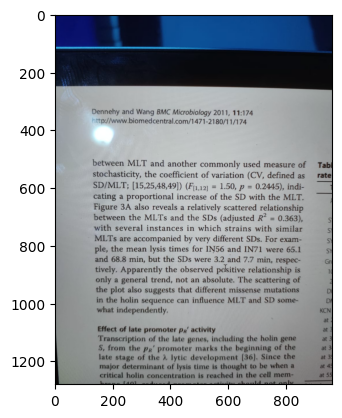

In [7]:
image2 = cv2.imread('./data/queries/1.jpeg')
plt.imshow(image2)

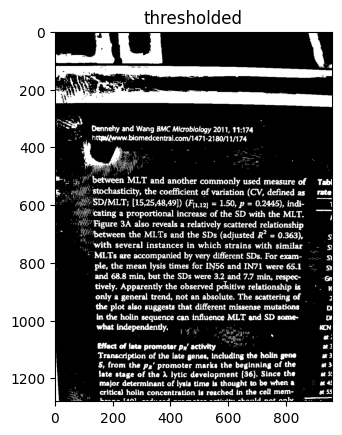

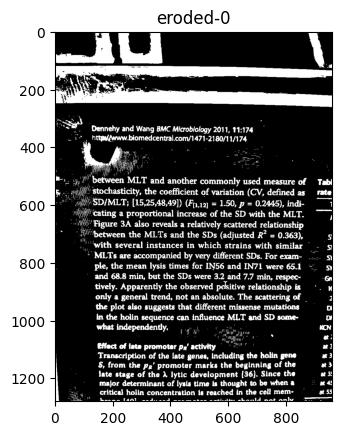

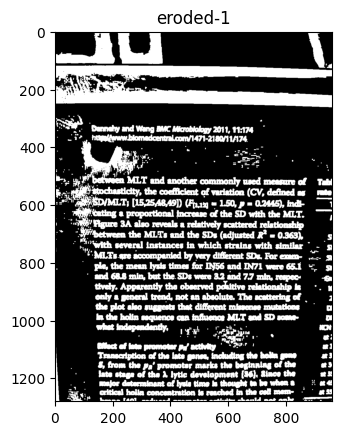

In [8]:
threshold(image2)

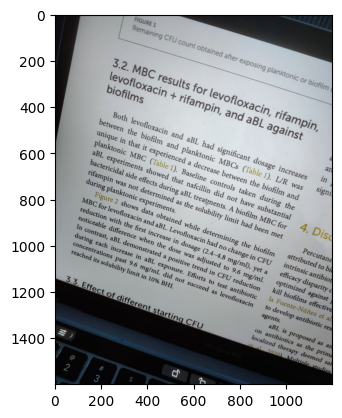

In [29]:
image3 = cv2.imread('./data/queries/cam_cap.jpeg')
plt.imshow(image3)

angle: 18.0


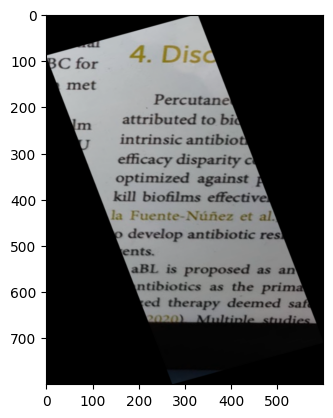

In [31]:
plt.imshow(standardize_image(image3))

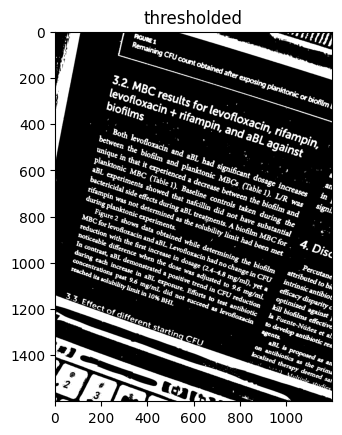

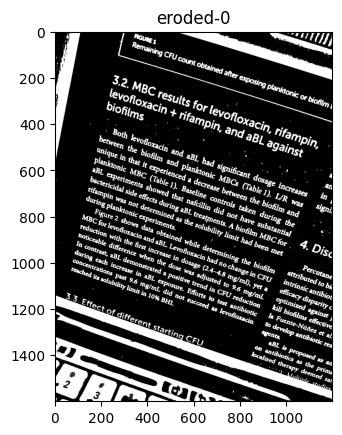

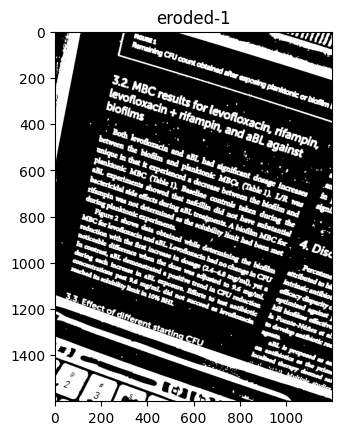

In [32]:
threshold(image3)

In [66]:
def standardize_image(img, target_width=800, target_height=600):

    def extract_ROI(image):
        gray = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray, (3, 3), 0)
        thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

        # Remove horizontal lines
        horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25,1))
        detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=1)
        cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        for c in cnts:
            cv2.drawContours(thresh, [c], -1, 0, -1)

        # Dilate to merge into a single contour
        vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,30))
        dilate = cv2.dilate(thresh, vertical_kernel, iterations=3)

        # Find contours, sort for largest contour and extract ROI
        cnts, _ = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]
        cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:-1]
        c = cnts[0]
        x,y,w,h = cv2.boundingRect(c)
        return image[y:y+h, x:x+w]

    def deskew(image):
        grayscale = rgb2gray(image)
        angle = np.round(determine_skew(grayscale),2)
        print("angle:", angle)
        rotated = (rotate(image, angle, resize=True) * 255).astype(np.uint8)
        return rotated

    img = deskew(img)
    # img = extract_ROI(img)
    scaled_image = cv2.resize(img, (target_width, target_height))
    return scaled_image

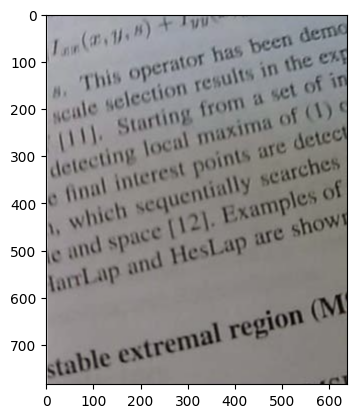

In [67]:
plt.imshow(extract_ROI(image))

angle: -12.0


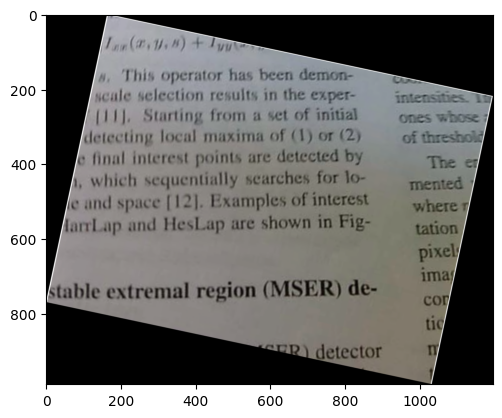

In [68]:
plt.imshow(deskew(image))

angle: -12.0


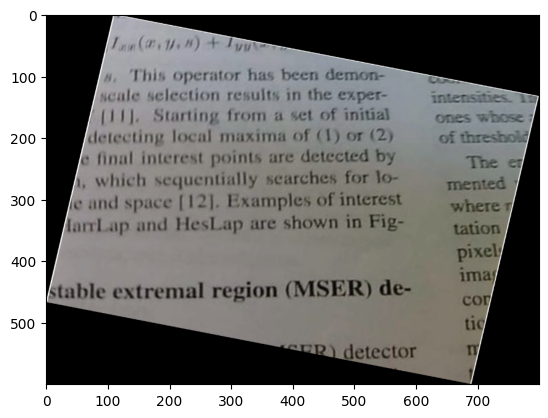

In [69]:
plt.imshow(standardize_image(image))

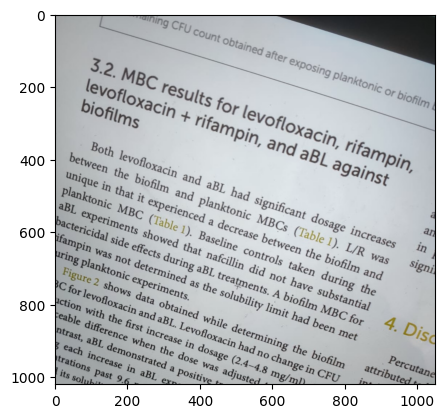

In [62]:
plt.imshow(extract_ROI(image3))

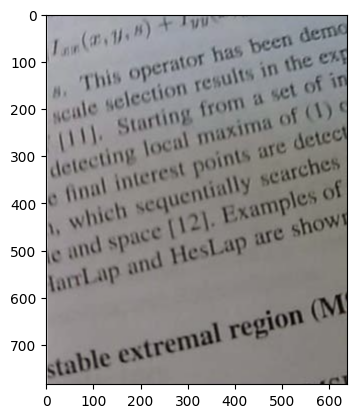

In [63]:
plt.imshow(extract_ROI(image))

angle: 19.0


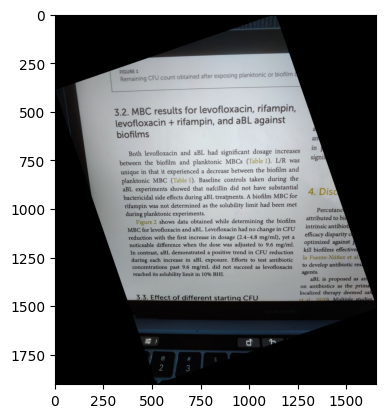

In [64]:
plt.imshow(deskew(image3))

angle: 19.0


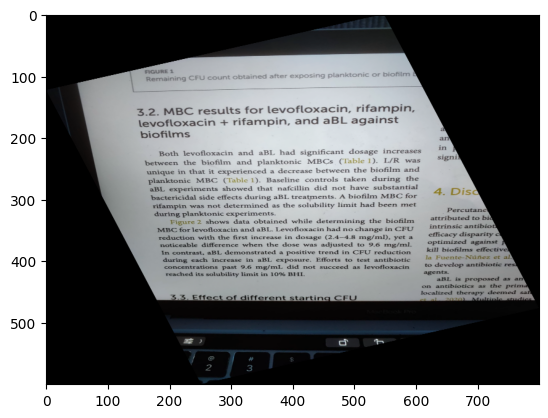

In [70]:
plt.imshow(standardize_image(image3))

angle: -12.0


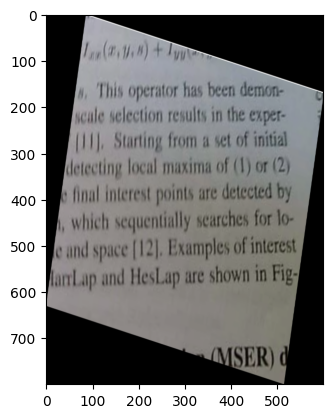

In [41]:
plt.imshow(standardize_image(image))

angle: -13.0


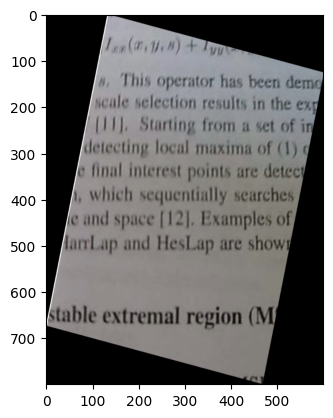

In [37]:
plt.imshow(standardize_image(image))

angle: -13.0


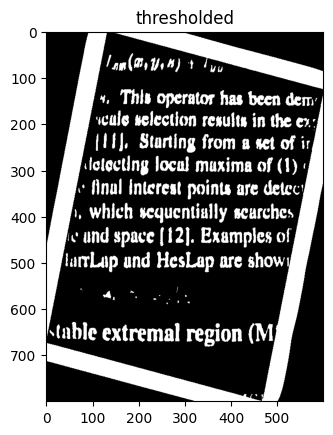

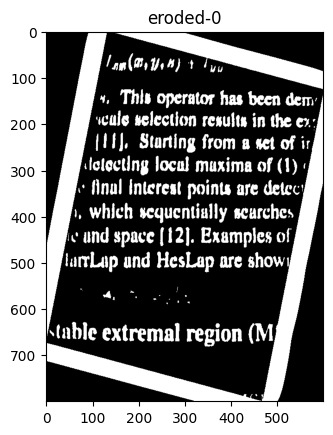

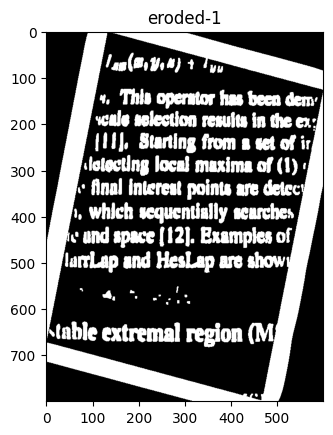

In [39]:
threshold(standardize_image(image))

angle: 18.0


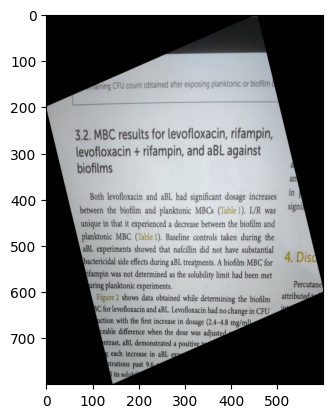

In [38]:
plt.imshow(standardize_image(image3))

angle: 18.0


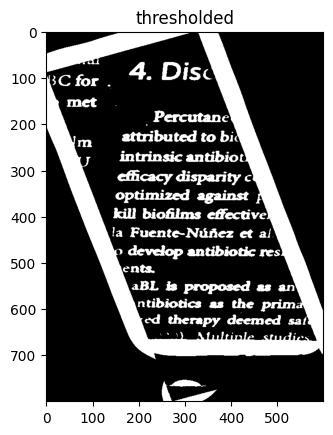

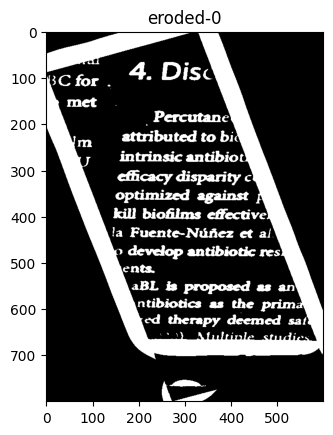

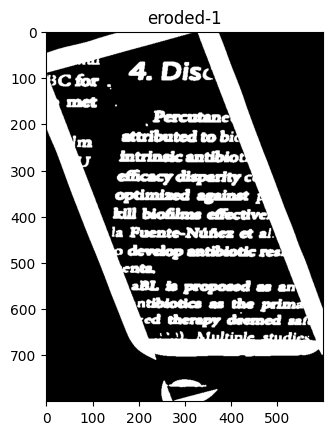

In [33]:
threshold(standardize_image(image3))